In [1]:
import sympy as sp 

In [2]:
def text_read(file_name:str):
    with open(f'./Text_file_decoupled/{file_name}.txt', 'r') as file:
        content = file.read()
    content = content.replace('np.log','log')
    content = sp.sympify(content)
    content = content.subs('ep',1)
    return content

In [3]:
z,t,r,u_c,d,d0,Q0,k,w = sp.symbols('z t r u_c d d0 Q0 k w')
A,B,delta = sp.symbols('A B delta', real = True, constant = True)
Q1 = sp.Function('Q1')(z,t)
d1 = sp.Function('d1')(z,t)

In [4]:
def taylor_expan(term):
    term_s = sp.Function(f"{term}")
    term_ts = sp.series(term_s(d),d,d0,2)
    term_ts = term_ts.removeO()
    term_ts = term_ts.subs(d-d0,d1*delta)
    return term_ts
def linearised(term):
    deg = term.as_poly(delta).degree()
    i = deg
    while i>1:
        term  = term.subs(delta**i,0) 
        i = i-1
    return term 

## Q_equation
$Q-N_cu_c+\partial_z(\frac{1}{d}-\frac{(\partial_z d)^2}{2d}-\partial^2_z d)*I+(J_mQ + J_cu_c)*(\partial_z d)^2+K_m \partial_z d \partial_z Q+(L_mQ+L_cu_c)*(\partial^2_z d)+M_m \partial^2_z Q = 0$

## curvature 
$\partial_z(\frac{1}{d}-\frac{(\partial_z d)^2}{2d}-\partial^2_z d)*I$

In [5]:
one_over_d_ts = (sp.series(1/(d),d,d0,3)).removeO()
one_over_d = one_over_d_ts.subs(d-d0,delta*d1)
one_over_d_lin = linearised(one_over_d)
one_over_d_lin

1/d0 - delta*d1(z, t)/d0**2

In [6]:
D1d2_2d_ts = (sp.diff(d0+delta*d1,z)**2*((sp.series(1/(d),d,d0,3)).removeO()))
D1d2_2d = sp.expand(D1d2_2d_ts.subs(d-d0,delta*d1))
D1d2_2d_lin = linearised(D1d2_2d)
D1d2_2d_lin

0

In [7]:
D2d = sp.diff(d0+delta*d1,z,z)
D2d_lin =linearised(D2d)
D2d_lin

delta*Derivative(d1(z, t), (z, 2))

In [8]:
lin_curvature = one_over_d_lin-D1d2_2d_lin-D2d_lin
lin_curvature_z = sp.diff(lin_curvature,z)
curvature_lin = linearised(sp.expand(lin_curvature_z*taylor_expan('I_w')))
curvature_lin

-delta*I_w(d0)*Derivative(d1(z, t), (z, 3)) - delta*I_w(d0)*Derivative(d1(z, t), z)/d0**2

## J_m & J_c
$(J_mQ + J_cu_c)*(\partial_z d)^2$

In [9]:
J_term = sp.expand((taylor_expan('J_m')*(Q0+delta*Q1)+taylor_expan('J_c')*u_c)*(sp.diff(d0+delta*d1,z))**2)
J_term_lin = linearised(J_term)
J_term_lin

0

## K_m 
$K_m \partial_z d \partial_z Q$

In [10]:
K_term = taylor_expan('K_m')*sp.diff(d0+delta*d1,z)*sp.diff(Q0+delta*Q1,z)
K_term_lin = linearised(K_term)
K_term_lin

0

## L_m & L_c 
$(L_mQ+L_cu_c)*(\partial^2_z d)$

In [11]:
L_term = sp.expand((taylor_expan('L_m')*(Q0+delta*Q1) + taylor_expan('L_c')*u_c)*sp.diff(d0+delta*d1,z,z))
L_term_lin = linearised(L_term) 
L_term_lin

Q0*delta*L_m(d0)*Derivative(d1(z, t), (z, 2)) + delta*u_c*L_c(d0)*Derivative(d1(z, t), (z, 2))

## M_m 
$M_m \partial^2_z Q$

In [12]:
M_term  = sp.expand(taylor_expan('M_m')*sp.diff(Q0+delta*Q1,z,z))
M_term_lin = linearised(M_term)
M_term_lin

delta*M_m(d0)*Derivative(Q1(z, t), (z, 2))

## N_c term 
$N_cu_c$

In [13]:
N_term  = text_read('Wm_r_1')*u_c
N_term = sp.expand(N_term.subs(d,d0+delta*d1))
N_term_lin = linearised(N_term)
N_term_lin

-d0**2*u_c/2 - d0*delta*u_c*d1(z, t) + u_c/2

In [14]:
text_read('Wm_r_1')

1/2 - d**2/2

## linearised equation

In [15]:
linequ = sp.expand((Q0+delta*Q1)-N_term_lin+curvature_lin+J_term_lin+K_term_lin+L_term_lin+M_term_lin)
linequ

Q0*delta*L_m(d0)*Derivative(d1(z, t), (z, 2)) + Q0 + d0**2*u_c/2 + d0*delta*u_c*d1(z, t) + delta*u_c*L_c(d0)*Derivative(d1(z, t), (z, 2)) - delta*I_w(d0)*Derivative(d1(z, t), (z, 3)) + delta*M_m(d0)*Derivative(Q1(z, t), (z, 2)) + delta*Q1(z, t) - u_c/2 - delta*I_w(d0)*Derivative(d1(z, t), z)/d0**2

In [16]:
Base_equ = sp.cancel(linequ-linequ.coeff(delta)*delta)
Base_equ

Q0 + d0**2*u_c/2 - u_c/2

In [17]:
perturb_equ_Q = linequ.coeff(delta)
print(perturb_equ_Q)

Q0*L_m(d0)*Derivative(d1(z, t), (z, 2)) + d0*u_c*d1(z, t) + u_c*L_c(d0)*Derivative(d1(z, t), (z, 2)) - I_w(d0)*Derivative(d1(z, t), (z, 3)) + M_m(d0)*Derivative(Q1(z, t), (z, 2)) + Q1(z, t) - I_w(d0)*Derivative(d1(z, t), z)/d0**2


In [18]:
normal_mode = (sp.exp(1j*k*z)*sp.exp(-1j*w*t))

In [19]:
perturb_equ_Q = perturb_equ_Q.subs([(d1,A*normal_mode),(Q1,B*normal_mode)]).doit()

## d_equation
$\partial_t d -\frac{1}{d}\partial_z Q$

In [20]:
one_over_d_ts = (sp.series(1/(d),d,d0,3)).removeO()
one_over_d = one_over_d_ts.subs(d-d0,delta*d1)
one_over_d_lin = linearised(one_over_d)
one_over_d_lin

1/d0 - delta*d1(z, t)/d0**2

In [21]:
d_equation_lin = linearised(sp.expand(sp.diff(d0+delta*d1,t)- one_over_d_lin*(sp.diff(Q0+delta*Q1,z))))
d_equation_lin

delta*Derivative(d1(z, t), t) - delta*Derivative(Q1(z, t), z)/d0

In [22]:
perturb_equ_d = d_equation_lin.subs([(d1,A*normal_mode),(Q1,B*normal_mode),(delta,1)]).doit()
perturb_equ_d

-1.0*I*A*w*exp(1.0*I*k*z)*exp(-1.0*I*t*w) - 1.0*I*B*k*exp(1.0*I*k*z)*exp(-1.0*I*t*w)/d0

In [23]:
A_coeff_pert_Q = sp.cancel(perturb_equ_Q.coeff(A))
B_coeff_pert_Q = sp.cancel(perturb_equ_Q.coeff(B))
A_coeff_pert_d = sp.cancel(perturb_equ_d.coeff(A))
B_coeff_pert_d = sp.cancel(perturb_equ_d.coeff(B))

In [24]:
dis_mat = sp.Matrix([[A_coeff_pert_Q, B_coeff_pert_Q],
            [A_coeff_pert_d, B_coeff_pert_d]])
dis_mat

Matrix([
[1.0*(-1.0*Q0*d0**2*k**2*L_m(d0)*exp(1.0*I*k*z) + 1.0*d0**3*u_c*exp(1.0*I*k*z) + 1.0*I*d0**2*k**3*I_w(d0)*exp(1.0*I*k*z) - 1.0*d0**2*k**2*u_c*L_c(d0)*exp(1.0*I*k*z) - 1.0*I*k*I_w(d0)*exp(1.0*I*k*z))*exp(-1.0*I*t*w)/d0**2, 1.0*(-1.0*k**2*M_m(d0)*exp(1.0*I*k*z) + 1.0*exp(1.0*I*k*z))*exp(-1.0*I*t*w)],
[                                                                                                                                                                                    -1.0*I*w*exp(1.0*I*k*z)*exp(-1.0*I*t*w),                                  -1.0*I*k*exp(1.0*I*k*z)*exp(-1.0*I*t*w)/d0]])

In [25]:
dis_rel = sp.expand(dis_mat.det())

In [26]:
omega_coeff = dis_rel.coeff(w)
omega_coeff  

-1.0*I*k**2*M_m(d0)*exp(2.0*I*k*z)*exp(-2.0*I*t*w) + 1.0*I*exp(2.0*I*k*z)*exp(-2.0*I*t*w)

In [27]:
wave_number_part = sp.expand(sp.cancel(dis_rel-dis_rel.coeff(w)*w))
wave_number_part

1.0*I*Q0*k**3*L_m(d0)*exp(2.0*I*k*z)*exp(-2.0*I*t*w)/d0 - 1.0*I*k*u_c*exp(2.0*I*k*z)*exp(-2.0*I*t*w) + 1.0*k**4*I_w(d0)*exp(2.0*I*k*z)*exp(-2.0*I*t*w)/d0 + 1.0*I*k**3*u_c*L_c(d0)*exp(2.0*I*k*z)*exp(-2.0*I*t*w)/d0 - 1.0*k**2*I_w(d0)*exp(2.0*I*k*z)*exp(-2.0*I*t*w)/d0**3

In [28]:
k,k_r,k_i,I_w,L_m,L_c,M_m,d0,Q0,u_c = sp.symbols('k k_r k_i I_w L_m L_c M_m d0 Q0 u_c' ,real=True)
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import fsolve
import matplotlib as mpl
ep =1
omega = sp.cancel(wave_number_part/-omega_coeff)
omega = sp.expand(omega)
omega_str = str(omega)
omega_str = omega_str.replace('L_m(d0)','L_m')
omega_str = omega_str.replace('L_c(d0)','L_c')
omega_str = omega_str.replace('M_m(d0)','M_m')
omega_str = omega_str.replace('I_w(d0)','I_w')
with open(f'../code/Text_file_decoupled/omega_str.txt', 'w') as file:
        file.write(omega_str)


In [29]:
I1= open("./Text_file_decoupled/Iw_mf.txt","r")
I1s = I1.read()
def I_f(d):
    return eval(I1s)

Lm1= open("./Text_file_decoupled/Lmm.txt","r")
Lm1s = Lm1.read()
def Lm_f(d):
    return eval(Lm1s)

Lc1= open("./Text_file_decoupled/Lmw.txt","r")
Lc1s = Lc1.read()
def Lc_f(d):
    return eval(Lc1s)

Mm1= open("./Text_file_decoupled/Mmm.txt","r")
Mm1s = Mm1.read()
def Mm_f(d):
    return eval(Mm1s)

In [30]:
with open(f'./Text_file_decoupled/omega_str.txt', 'r') as file:
       omega_str = file.read()
omega = sp.sympify(omega_str,locals={'k': k, 'L_c': L_c,'M_m': M_m, 'L_m': L_m,'d0': d0, 'Q0': Q0,'I_w': I_w})
omega

-1.0*I*I_w*d0**3*k**4/(1.0*M_m*d0**4*k**2 - 1.0*d0**4) + 1.0*I*I_w*d0*k**2/(1.0*M_m*d0**4*k**2 - 1.0*d0**4) + 1.0*L_c*d0**3*k**3*u_c/(1.0*M_m*d0**4*k**2 - 1.0*d0**4) + 1.0*L_m*Q0*d0**3*k**3/(1.0*M_m*d0**4*k**2 - 1.0*d0**4) - 1.0*d0**4*k*u_c/(1.0*M_m*d0**4*k**2 - 1.0*d0**4)

In [31]:
omega_exp = sp.simplify(omega.subs(k,k_r+1j*k_i))
omega_exp_nu,omega_exp_de  = sp.fraction(omega_exp)
omega_exp_de = sp.expand(omega_exp_de)
omega_exp_nu = sp.expand(omega_exp_nu)
omega_exp_de_con = sp.conjugate(omega_exp_de)

In [32]:
omega_exp_de = sp.expand(omega_exp_de*omega_exp_de_con)
omega_exp_nu = sp.expand(omega_exp_nu*omega_exp_de_con)
omega_exp = sp.expand(omega_exp_nu/omega_exp_de)

In [33]:
Im_omega = omega_exp.coeff(sp.I)
Im_omega_str = str(Im_omega)
Re_omega = sp.cancel(omega_exp-Im_omega*1j)
Re_omega_str = str(Re_omega)
sp.cancel(1j*Im_omega+Re_omega-omega_exp)

0

In [34]:
dwdk = sp.simplify(sp.diff(omega,k).subs(k,k_r+1j*k_i))
dwdk_nu,dwdk_de = sp.fraction(dwdk)
dwdk_nu = sp.expand(dwdk_nu)
dwdk_de = sp.expand(dwdk_de)
dwdk_de_con = sp.conjugate(dwdk_de)
dwdk_nu = sp.expand(dwdk_nu*dwdk_de_con)
dwdk_de = sp.expand(dwdk_de*dwdk_de_con)
dwdk = sp.expand(dwdk_nu/dwdk_de)
dwdk_im = sp.expand(dwdk.coeff(sp.I))
dwdk_Re = sp.expand(sp.cancel(dwdk-dwdk_im*1j))
def func(var,d0,u_c):
    Q0 = (1-d0**2)/2*u_c
    I_w = I_f(d0)
    L_m = Lm_f(d0)
    M_m = Mm_f(d0)
    L_c = Lc_f(d0)
    k_r,k_i = var
    eq1 = eval(str(dwdk_Re))
    eq2 = eval(str(dwdk_im))
    return [eq1,eq2]
def kr_ki(d0,u_c):
    try:
        solution = fsolve(func, [-1,0],args=(d0,u_c))
        k_r = solution[0]
        k_i = solution[1]
        return np.float64([k_r,k_i])
    except ValueError:
            return "solver failed"  

In [35]:
def omega_Im(k_r,k_i,d0,u_c):
    Q0 = (1-d0**2)/2*u_c
    I_w = I_f(d0)
    L_m = Lm_f(d0)
    M_m = Mm_f(d0)
    L_c = Lc_f(d0)
    return eval(Im_omega_str)
def omega_Re(k_r,k_i,d0,u_c):
    Q0 = (1-d0**2)/2*u_c
    I_w = I_f(d0)
    L_m = Lm_f(d0)
    M_m = Mm_f(d0)
    L_c = Lc_f(d0)
    return eval(Re_omega_str)

kr = np.linspace(-3,3,1000)
ki = np.linspace(-3,3,1000)
Kr,Ki = np.meshgrid(kr,ki)

In [36]:
n_gen = 14
R0  = 1
ep = 1
R = (R0*2**(-n_gen/3))*(1e-2)
gamma_am = 0.05
mu_m = 0.01
u_char = gamma_am/mu_m
d0_star = 0.97
Lamnda_R = 2*np.pi*d0_star*np.sqrt(2)
alpha_star = 2*np.pi*d0_star/(Lamnda_R)
tau = (6*mu_m*R*d0_star/gamma_am)/(alpha_star**4*(1/alpha_star**2-1)*(1/d0_star-1)**2*(1/d0_star**2-1))
T =  tau/(R/u_char)
omega_scale = 1/T

In [44]:
def plot_contour(ax,d0,u_c,k):
    k_r0 = k[0]
    k_i0 = k[1]
    Q0 = (1-d0**2)/2*u_c
    oup = 2
    inp = -2
    lb = np.arange(inp,oup,(oup-inp)/80)
    ax.contour(kr,ki,omega_Im(Kr,Ki,d0,u_c)/omega_scale,levels = lb,cmap='coolwarm')
    
    ax.contour(kr,ki,omega_Im(Kr,Ki,d0,u_c)/omega_scale,levels = [0],colors='k', linestyles=':')
    ax.scatter(k_r0,k_i0,color = 'red', marker='+',s=75)
    ax.set_xlim(-1.2,-0.5)
    ax.set_ylim(-0.5,0.0)
    ax.set_yticks([-0.4,-0.2,0.0])
    ax.set_title(fr"$1-d_0 ={round(1-d0,3)}$",fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    norm = mpl.colors.Normalize(vmin=lb.min(), vmax=lb.max())
    sm = mpl.cm.ScalarMappable(norm=norm, cmap='coolwarm')
    cbar11 = fig.colorbar(sm,ax = ax)
    cbar11.set_ticks([-1.5,-0.5,0.5,1.5])
    cbar11.ax.set_title(r"$\omega_i$", fontsize=12, pad=10)
    ax.set_xlabel(r"$k_r$",fontsize=12)
    ax.set_ylabel(r"$k_i$",fontsize=12)
    return None

In [38]:
d01 = 0.971
uc  = 7.9e-6*1.5
k_r01 = kr_ki(d01,uc)[0]
k_i01 = kr_ki(d01,uc)[1]
d02 = 0.973
k_r02 = kr_ki(d02,uc)[0]
k_i02 = kr_ki(d02,uc)[1]

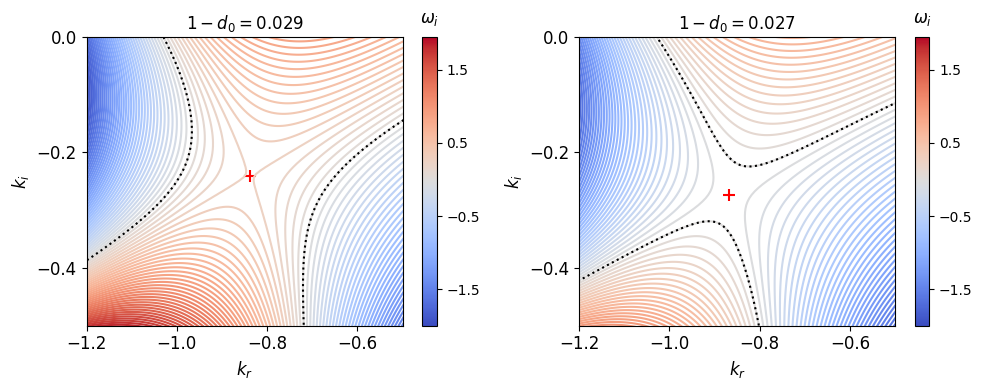

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns
plot_contour(axs[0],d01,uc,[k_r01,k_i01])
plot_contour(axs[1],d02,uc,[k_r02,k_i02])
plt.tight_layout()
plt.show()